In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline

## Lookup table
Siemens Sinamics S120 taken from [Schimpe et al.](https://doi.org/10.1016/j.egypro.2018.11.065)

In [2]:
df = pd.read_csv("../data/converter/sinamics_S120_efficiency.csv")
df.index = np.linspace(0, 1, 1001)

In [3]:
# df["Charging"].plot()

## Quadratic function to approximate conversion losses

In [4]:
p = np.linspace(0, 1, 1001)
l = p - p * df["Charging"]
loss_interp = make_interp_spline(p, l.values, k=1) # lookup-table

In [5]:
def converter_loss(power, k0, k1, k2, m0):
    return k0 * (1 - np.exp(-m0 * power)) + k1 * power + k2 * power ** 2

In [6]:
def fit_polynomial(loss_interp):
    p = np.arange(0.05, 1.0, 0.01)
    l = loss_interp(p)

    # popt, pcov = curve_fit(converter_loss, p, l)
    param = np.polyfit(p, l, 2)
    return param[::-1]

In [7]:
param = fit_polynomial(loss_interp)
param

array([0.00601144, 0.00863612, 0.01195589])

In [8]:
def fit_m0(param, loss_interp):
    p = np.linspace(0, 1, 1001)
    l = loss_interp(p)

    return curve_fit(lambda p, m0: converter_loss(p, *param, m0), p, l)

fit_m0(param, loss_interp)

(array([97.00502687]), array([[0.88544699]]))

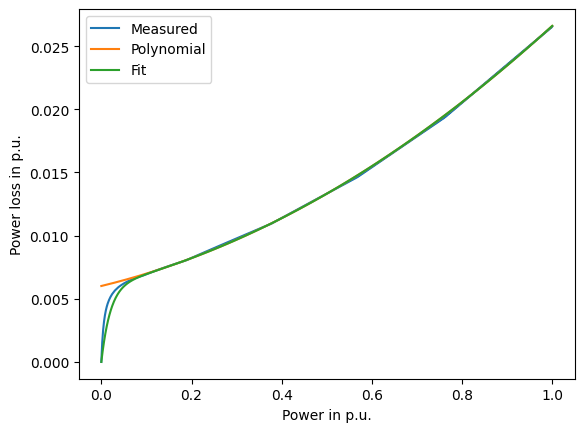

In [9]:
def plot_fit(param, loss_interp):
    poly = np.poly1d(param[::-1])
    p = np.linspace(0, 1, 1001)

    fig, ax = plt.subplots()
    ax.set_xlabel("Power in p.u.")
    ax.set_ylabel("Power loss in p.u.")
    ax.plot(p, loss_interp(p), label="Measured")
    ax.plot(p, poly(p), label="Polynomial")
    # ax.plot(p, converter_loss(p, *param, m0=100), label="Fit")
    ax.plot(p, converter_loss(p, *param, m0=50), label="Fit")
    ax.legend()
    return fig

fig1 = plot_fit(param, loss_interp)

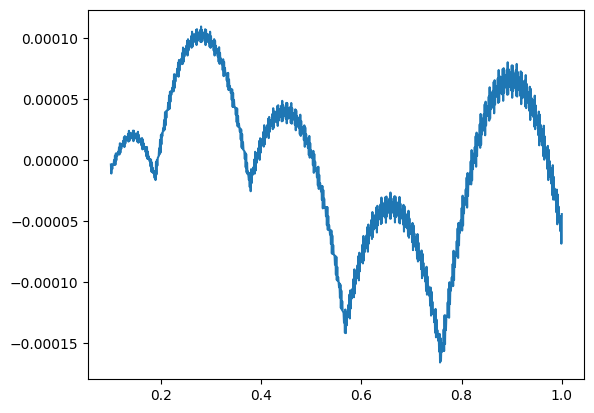

In [14]:
def plot_diff(param, loss_interp):
    p = np.linspace(0.1, 1, 1001)

    fig, ax = plt.subplots()
    ax.plot(p, (loss_interp(p) - converter_loss(p, *param, m0=50)), label="Fit error")
    # ax.plot(p, (loss_interp(p) - converter_loss(p, *param, m0=50)) / loss_interp(p), label="Fit error")

    return fig

fig = plot_diff(param, loss_interp)

## Efficiency curve

C:\Users\wsworker\AppData\Local\Temp\ipykernel_38732\705177512.py:5: RuntimeWarning: invalid value encountered in divide
  eff1 = (p - l1) / p
C:\Users\wsworker\AppData\Local\Temp\ipykernel_38732\705177512.py:9: RuntimeWarning: invalid value encountered in divide
  eff2 = (p - l2) / p


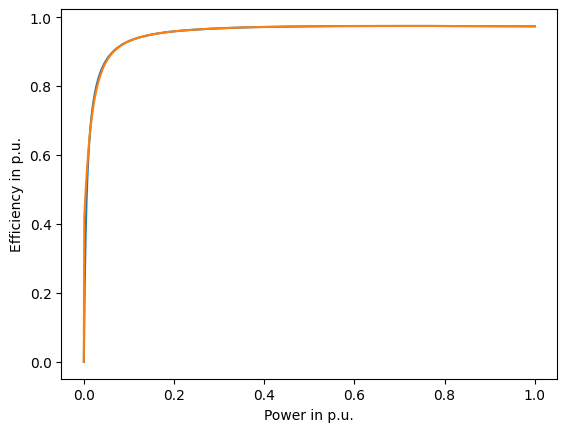

In [10]:
def plot_efficiency(param, loss_interp):
    p = np.linspace(0, 1, 1001)
    
    l1 = loss_interp(p)
    eff1 = (p - l1) / p
    eff1[0] = 0

    l2 = converter_loss(p, *param, m0=100)
    eff2 = (p - l2) / p
    eff2[0] = 0

    fig, ax = plt.subplots()
    ax.set_xlabel("Power in p.u.")
    ax.set_ylabel("Efficiency in p.u.")
    ax.plot(p, eff1)
    ax.plot(p, eff2)

    return fig

fig2 = plot_efficiency(param, loss_interp)